k-Means Clustering

We will move on to another class of unsupervised machine learning models: clustering algorithms.
Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

We begin with the standard imports:

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

## Introducing k-Means

The *k*-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.


To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

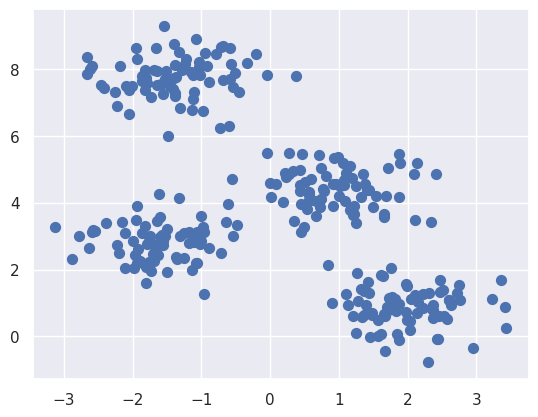

In [32]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [33]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, n_init='auto')
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Let's visualize the results by plotting the data colored by these labels.
We will also plot the cluster centers as determined by the *k*-means estimator:

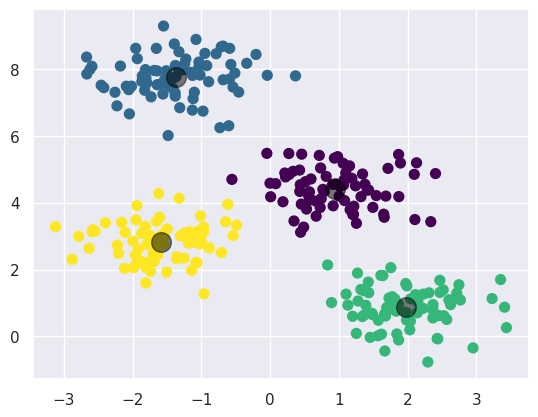

In [34]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## k-Means Algorithm: Expectation–Maximization

The *k*-Means algorithm is simple enough that we can write it in a few lines of code.
The following is a very basic implementation:

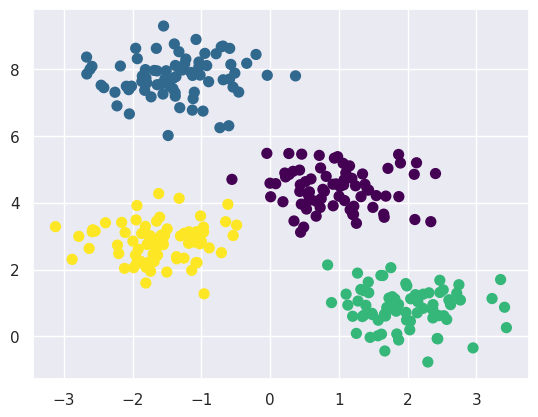

In [35]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the expectation–maximization approach.

#### The globally optimal result may not be achieved

For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

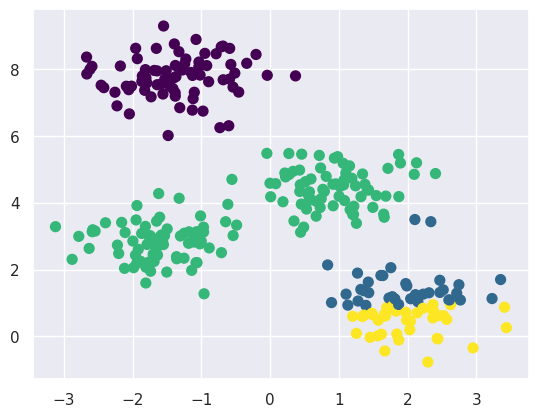

In [36]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### The number of clusters must be selected beforehand
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

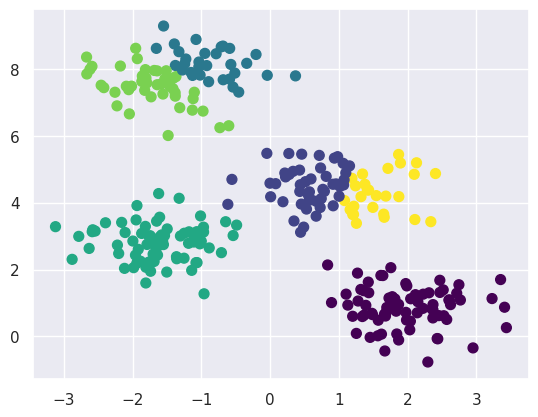

In [37]:
labels = KMeans(6, random_state=0, n_init='auto').fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### k-means is limited to linear cluster boundaries
The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.


Consider the following data, along with the cluster labels found by the typical *k*-means approach:

In [38]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

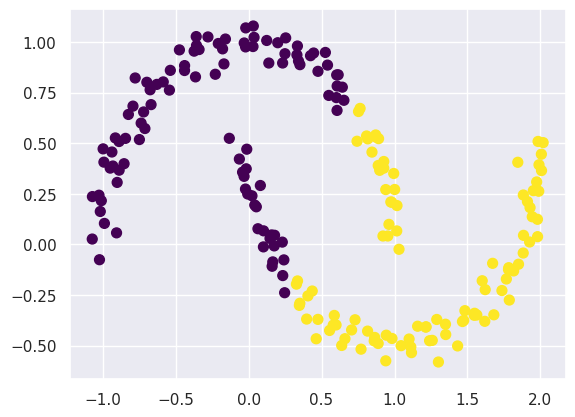

In [39]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

One version of this kernelized *k*-means is implemented in Scikit-Learn within the ``SpectralClustering`` estimator.
It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a *k*-means algorithm:

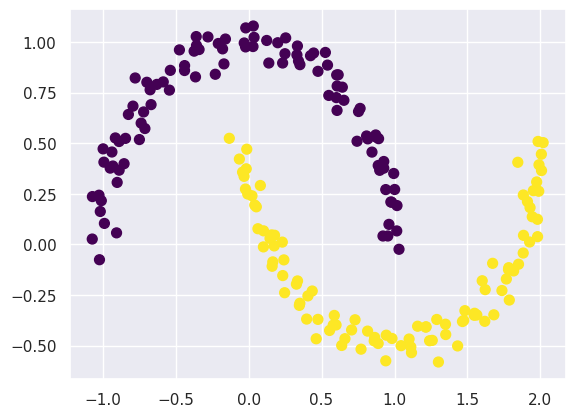

In [40]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

We see that with this kernel transform approach, the kernelized *k*-means is able to find the more complicated nonlinear boundaries between clusters.

### Example 1: k-means on digits

Here we will attempt to use *k*-means to try to identify similar digits *without using the original label information*; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any *a priori* label information.


In [41]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The clustering can be performed as we did before:

In [42]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

The result is 10 clusters in 64 dimensions.
Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster.
Let's see what these cluster centers look like:

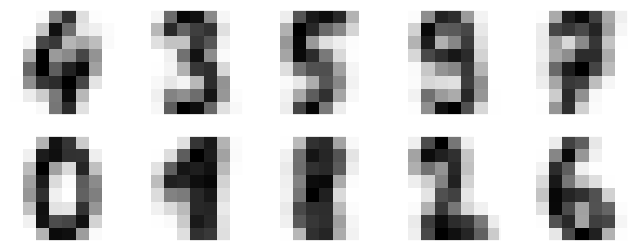

In [43]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that *even without the labels*, ``KMeans`` is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Because *k*-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted.
We can fix this by matching each learned cluster label with the true labels found in them:

In [44]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [45]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

With just a simple *k*-means algorithm, we discovered the correct grouping for 80% of the input digits!
Let's check the confusion matrix for this:

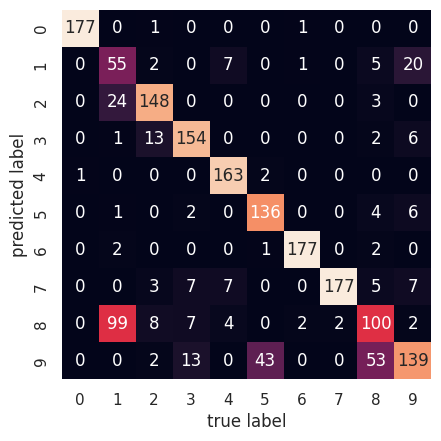

In [46]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones.

t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters.
Let's see how it does:

In [47]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9415692821368948

That's nearly 92% classification accuracy *without using the labels*.

### Example 2: *k*-means for color compression

One interesting application of clustering is in color compression within images.

For example, consider the image shown in the following figure, which is from the Scikit-Learn ``datasets`` module (for this to work, you'll have to have the ``pillow`` Python package installed).

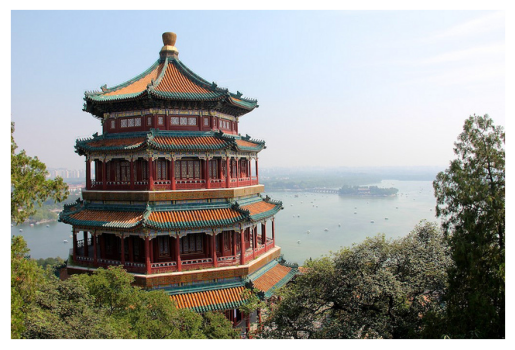

In [48]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

The image itself is stored in a three-dimensional array of size ``(height, width, RGB)``, containing red/blue/green contributions as integers from 0 to 255:

In [49]:
china.shape

(427, 640, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space.
We will reshape the data to ``[n_samples x n_features]``, and rescale the colors so that they lie between 0 and 1:

In [50]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency:

In [51]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

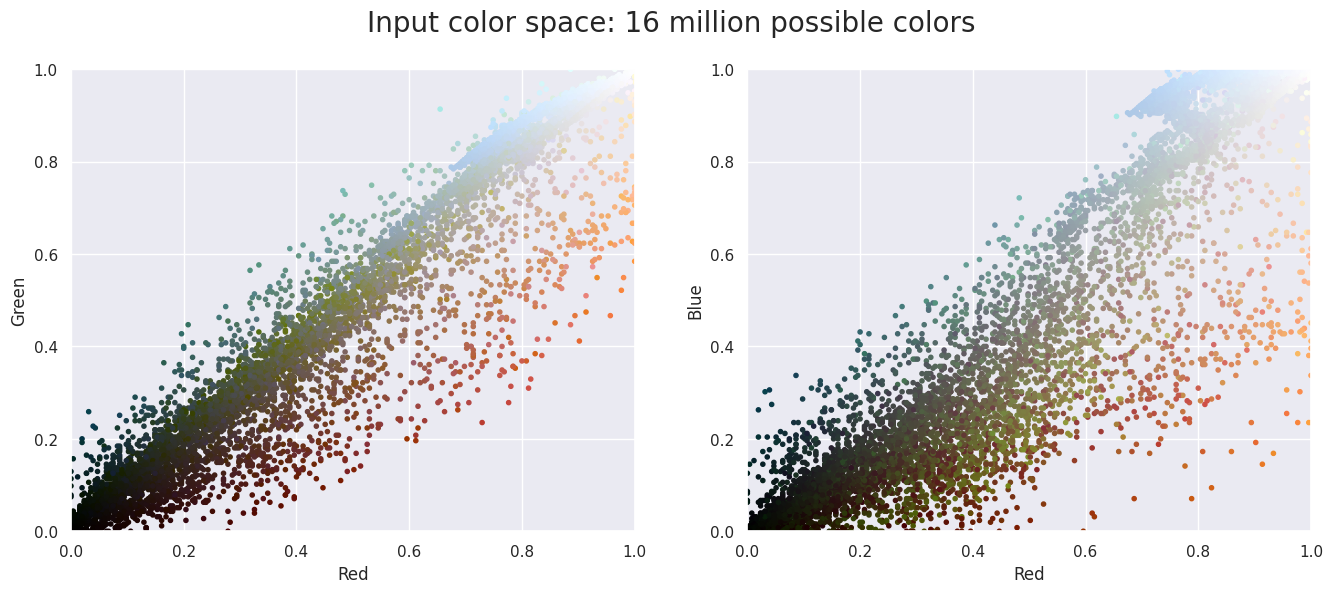

In [52]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 16 colors, using a *k*-means clustering across the pixel space.

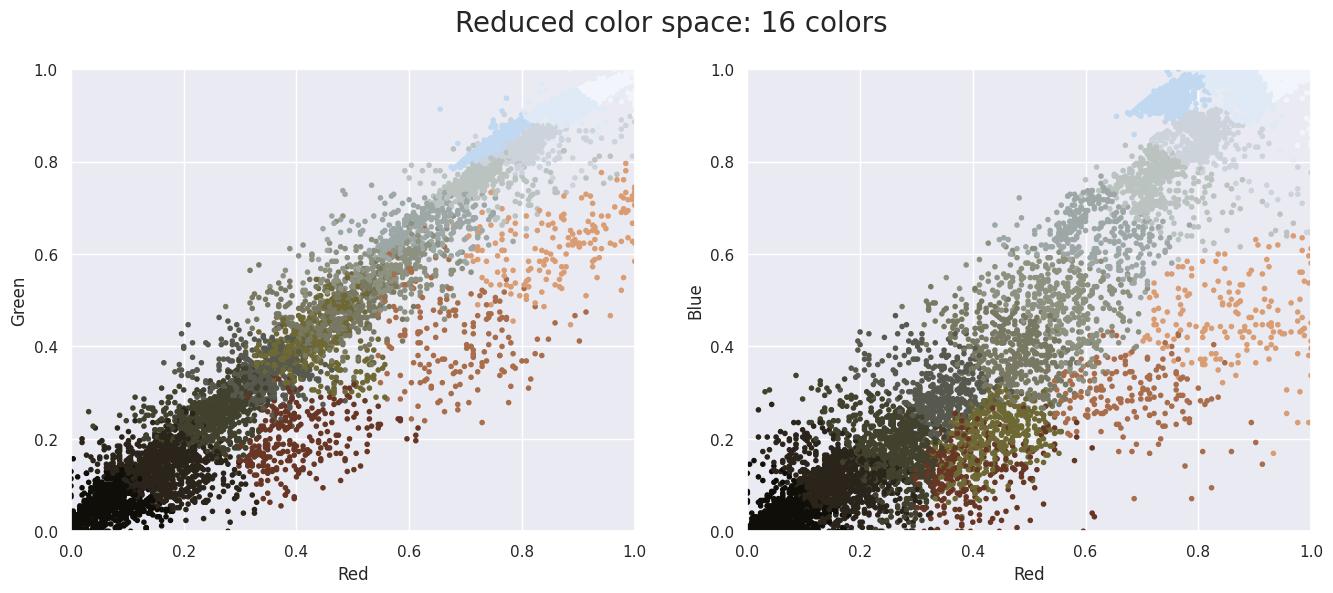

In [53]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center.
Plotting these new colors in the image space rather than the pixel space shows us the effect of this:

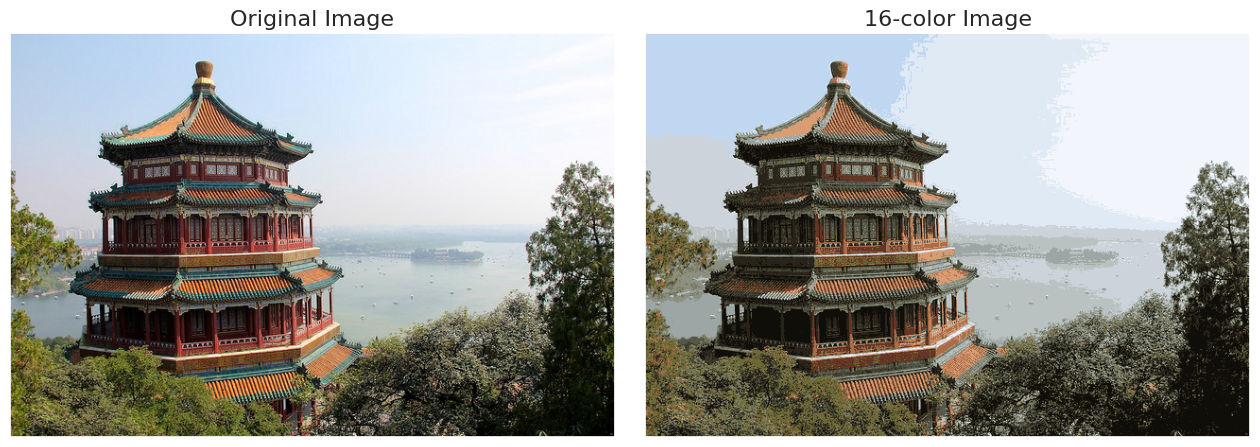

In [54]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable.